In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr
from itertools import product
import pysal as ps
import libpysal
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
import scipy.sparse

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def aff_prop_labels(idxs,obu,obv):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    X[:,0] = obu[idxs]
    X[:,1] = obv[idxs]
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = AffinityPropagation(
                                     damping=dampCoef,
                                     max_iter=iterMax,
                                     convergence_iter=iterCnv,
                                     copy=cop,
                                     preference=pref,
                                     affinity=affTyp,
                                     verbose=outVerb,
                                     random_state=randState
                                    ).fit(X)
    return clustering.labels_

def optics_labels(idxs,obu,obv):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    feat1 = obu[idxs]
    feat2 = obv[idxs]
    X[:,0] = feat1
    X[:,1] = feat2
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = OPTICS(
                        min_samples=8,          # how many obs necessary to create a cluster
                        max_eps=np.sqrt(2*7.),  # how close in X-space obs need to be to be clustered
                        n_jobs=1
                       ).fit(X)
    # compute empirical centers for all clusters with labels != -1
    cluLabels = np.unique(clustering.labels_)
    mask = np.ones(len(cluLabels), dtype=bool)
    mask[np.where(cluLabels==-1)] = False
    cluLabels = cluLabels[mask]  # removing the clustering.lanels_==-1 non-cluster
    nClusters = np.size(cluLabels)
    clusterCenters = np.nan * np.ones((nClusters,2))
    for i in range(np.size(cluLabels)):
        clu = cluLabels[i]
        mems = np.where(clustering.labels_ == clu)[0]
        clusterCenters[i,0] = np.mean(feat1[mems])
        clusterCenters[i,1] = np.mean(feat2[mems])
        
    return clustering.labels_, clusterCenters

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [3]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [4]:
# Pre-screening for pressure and time into discrete groups, then use DistanceBand grouping
# and pressure/time NearestNeighbors against all obs to reach out and include obs outside
# of initial screening. Use this expanded group to test for similarity via clustering with
# affinity propagation
#
# Perform similarity-based clustering on DistanceBand connected-groups, which can include
# multiple proximity-based clusters but will contain no observations with proximity-neighbors
# outside of the connected-group.
#
# define index of all qualifiable observations (meeting use and typ requirements)
allidx=np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))[0]
# define index of all searching observations (meeting pressure and time requirements in subset)
thresPres = 50. # +/- range of pressure bin
thresTime = 1.0  # +/- range of time bin
srcPres = 450.  # center of pressure bin
srcTime = -2.5  # center of time bin
minPres = srcPres - thresPres
maxPres = srcPres + thresPres
minTime = srcTime - thresTime
maxTime = srcTime + thresTime
srcidx=np.intersect1d(allidx,np.where((ob_pre <= maxPres)&(ob_pre >= minPres) &
                                      (ob_tim <= maxTime)&(ob_tim >= minTime))[0])
# define index of all expanding observations (qualifiable and within threshPres and threshTime of pressure/time req.)
minPresExp = minPres - thresPres
maxPresExp = maxPres + thresPres
minTimeExp = minTime - thresTime
maxTimeExp = maxTime + thresTime
expidx=np.intersect1d(allidx,np.where((ob_pre <= maxPresExp)&(ob_pre >= minPresExp) &
                                      (ob_tim <= maxTimeExp)&(ob_tim >= minTimeExp))[0])
print('{:d} observations in total'.format(np.size(allidx)))
print('{:d} observations in search'.format(np.size(srcidx)))
print('{:d} observations in expanded range'.format(np.size(expidx)))

582778 observations in total
20266 observations in search
62364 observations in expanded range


In [5]:
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in expidx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 
     'lat': list(ob_lat[expidx]),
     'lon': list(ob_lon[expidx]),
     'pre': list(ob_pre[expidx]),
     'tim': list(ob_tim[expidx]),
     'uob': list(ob_uwd[expidx]),
     'vob': list(ob_vwd[expidx]),
     'ob_idx': list(expidx)
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")
# Generate neighbors search in pressure and time space with chosen thresholds
#neighPres = NearestNeighbors(radius=thresPres)
#neighPres.fit(np.reshape(ob_pre[expidx],(-1,1)))
#neighTime = NearestNeighbors(radius=thresTime)
#neighTime.fit(np.reshape(ob_tim[expidx],(-1,1)))

In [6]:
gdfE

,geometry,lat,lon,pre,tim,uob,vob,ob_idx
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,0
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,3
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4
...,...,...,...,...,...,...,...,...
62359,POINT (-115960.068 8143677.431),73.155899,-1.041687,512.000000,-1.050000,8.776244,8.183980,1850189
62360,POINT (-682287.106 9376833.460),84.233528,-6.129089,419.700012,-0.900000,12.279324,-1.725746,1850208
62361,POINT (-646052.557 9362170.290),84.101807,-5.803589,420.200012,-0.900000,12.247335,-1.939787,1850210
62362,POINT (-602663.503 9360460.648),84.086449,-5.413818,420.200012,-0.900000,11.975852,-2.327870,1850211


In [7]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3427 disconnected components.
 There are 1726 islands with ids: 24, 25, 28, 39, 40, 45, 294, 1392, 1393, 1394, 1395, 1412, 1437, 1439, 1450, 1459, 1463, 1464, 1473, 1479, 1486, 1487, 1551, 1705, 2832, 3042, 3043, 3045, 3052, 3053, 3054, 3066, 3077, 3086, 3096, 3097, 3119, 3125, 3143, 3144, 3145, 3146, 3147, 3155, 3221, 3229, 3235, 3256, 3258, 3261, 3275, 3289, 3298, 3345, 3346, 3358, 3371, 3434, 4213, 4227, 4273, 4297, 4319, 4333, 4344, 4345, 4355, 4358, 4359, 4360, 4361, 4363, 4364, 4365, 4366, 4368, 4371, 4372, 4380, 4383, 4385, 4387, 4391, 4392, 4393, 4397, 4398, 4402, 4415, 4427, 4438, 4439, 4440, 4443, 4459, 4488, 4490, 4491, 4492, 4493, 4494, 4497, 4502, 4644, 4646, 4648, 4651, 4669, 4694, 5304, 5312, 5337, 5346, 5589, 5599, 5600, 5608, 5634, 5641, 5645, 5651, 5661, 5668, 5676, 5679, 5685, 5694, 5698

In [8]:
# trim islands from gdfE, as these are 1-member clusters by definition, recompute w
gdfE=gdfE.drop(index=w.islands)
gdfE=gdfE.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1701 disconnected components.
  warnings.warn(message)


In [9]:
ws = w.sparse
wt = scipy.sparse.triu(ws)
iprox,jprox=scipy.sparse.find(wt)[0:2]

In [10]:
# attach component-groups to gdfE
gdfE = gdfE.assign(compGroup=w.component_labels)
gdfE

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup
0,0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.55,-3.314330,13.293052,0,0
1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.55,-13.800393,8.292113,1,1
2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.55,-11.190902,9.062214,2,1
3,3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.55,-8.955636,14.332013,3,2
4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.55,-10.281547,13.159780,4,1
...,...,...,...,...,...,...,...,...,...,...
60633,62358,POINT (-164529.854 8215490.868),73.801010,-1.477997,500.000000,-1.05,5.332906,9.620817,1850188,1697
60634,62359,POINT (-115960.068 8143677.431),73.155899,-1.041687,512.000000,-1.05,8.776244,8.183980,1850189,1697
60635,62360,POINT (-682287.106 9376833.460),84.233528,-6.129089,419.700012,-0.90,12.279324,-1.725746,1850208,1700
60636,62361,POINT (-646052.557 9362170.290),84.101807,-5.803589,420.200012,-0.90,12.247335,-1.939787,1850210,1700


In [11]:
# extract all component-neighbors from a component of w
ic = 1  # component-label to search on
gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
compIDX = gdfEsub.index
print('{:d} observations in component sub-group'.format(np.size(compIDX)))
# compute pressure and time proximity-neighbor lists among expidx[compIDX]
neighPres = NearestNeighbors(radius=thresPres)
neighPres.fit(np.reshape(gdfEsub['pre'].values,(-1,1)))
neighPresList = neighPres.radius_neighbors(np.reshape(gdfEsub['pre'].values,(-1,1)),return_distance=False)
neighTime = NearestNeighbors(radius=thresTime)
neighTime.fit(np.reshape(gdfEsub['tim'].values,(-1,1)))
neighTimeList = neighTime.radius_neighbors(np.reshape(gdfEsub['tim'].values,(-1,1)),return_distance=False)
# compute equivalent space proximity-neighbor list
neighSpacList = np.empty((np.shape(neighPresList)),dtype='O')
for i in range(np.size(compIDX)):
    neighSpacList[i] = jprox[np.where(iprox==compIDX[i])]
neighSpacList
gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
gdfEsub = gdfEsub.reset_index()
gdfEsub

6006 observations in component sub-group


,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup
0,1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,1
1,2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,1
2,4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,1
3,5,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,1
4,6,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,1
...,...,...,...,...,...,...,...,...,...,...,...
6001,60409,62102,POINT (-489570.673 -7269285.388),-65.301102,-4.397888,487.0,-1.00,-12.082952,14.921203,1822227,1
6002,60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.00,-10.927389,13.022756,1822229,1
6003,60411,62104,POINT (-97458.910 -7528660.854),-67.631111,-0.875488,500.0,-1.00,-5.128942,10.515890,1822231,1
6004,60412,62105,POINT (-234984.411 -7602241.686),-68.292099,-2.110901,450.0,-1.00,-2.541947,11.010382,1822232,1


In [12]:
# test of pressure and time neighbor lists
print(np.min(neighPresList[0]),np.max(neighPresList[0]))
print(np.min(neighTimeList[0]),np.max(neighTimeList[0]))

0 6005
0 5990


In [13]:
# neighPresList and neighTimeList key into gdfEsub.index values

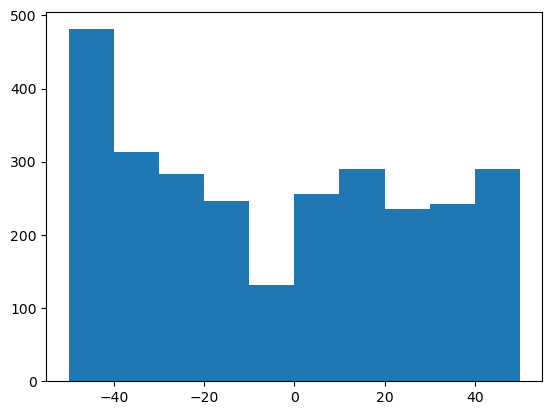

In [14]:
i=6005


plt.hist(gdfEsub.loc[gdfEsub.index.isin(neighPresList[i])]['pre'].values - gdfEsub.loc[gdfEsub.index==i]['pre'].values)
plt.show()

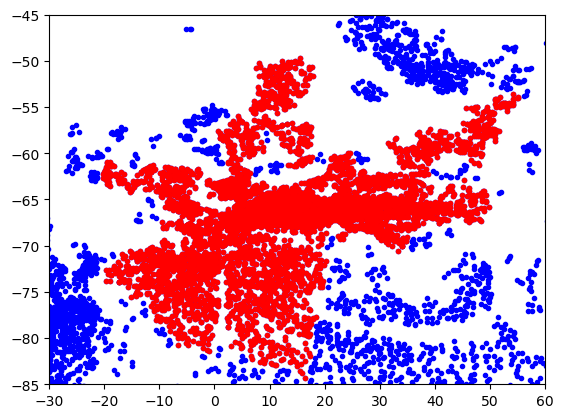

In [15]:
plt.plot(gdfE['lon'].values,gdfE['lat'].values,'.',color='blue')
plt.plot(gdfEsub['lon'].values,gdfEsub['lat'].values,'.',color='red')
plt.xlim((-30.,60.))
plt.ylim((-85.,-45.))
plt.show()

In [16]:
ob_sim = np.nan * np.ones((len(gdfEsub),))
ob_sim, clusterCenters = optics_labels(gdfEsub['ob_idx'].values,ob_uwd,ob_vwd)  # similarity-labels, from OPTICS clustering
print('{:d} observations reduced to {:d} clusters with {:d} singles'.format(np.size(compIDX),
                                                                            np.size(np.unique(ob_sim))-1,
                                                                            np.size(np.where(ob_sim==-1))))

6006 observations reduced to 177 clusters with 3510 singles


In [17]:
# use clusterCenters to initialize a k-means search to assign each observation to a cluster
idxs = gdfEsub['ob_idx'].values
obu = ob_uwd
obv = ob_vwd
n_feat = 2
X = np.nan * np.ones((np.size(idxs),n_feat))
feat1 = obu[idxs]
feat2 = obv[idxs]
X[:,0] = feat1
X[:,1] = feat2
clustering = KMeans(n_clusters=np.shape(clusterCenters)[0],
                    init=clusterCenters,
                    n_init=1).fit(X)
ob_sim = clustering.labels_

In [18]:
# remove (ob_sim == -1) observations from clustering search - these are unique (u,v) values with no
# similarity neighbors
gdfEsub = gdfEsub.assign(similGroup=ob_sim)
#gdfEsub = gdfEsub.drop(index=gdfEsub.loc[gdfEsub['similGroup']==-1].index)
#gdfEsub=gdfEsub.reset_index()
gdfEsub

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
0,1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,1,115
1,2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,1,55
2,4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,1,159
3,5,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,1,47
4,6,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,1,54
...,...,...,...,...,...,...,...,...,...,...,...,...
6001,60409,62102,POINT (-489570.673 -7269285.388),-65.301102,-4.397888,487.0,-1.00,-12.082952,14.921203,1822227,1,162
6002,60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.00,-10.927389,13.022756,1822229,1,159
6003,60411,62104,POINT (-97458.910 -7528660.854),-67.631111,-0.875488,500.0,-1.00,-5.128942,10.515890,1822231,1,59
6004,60412,62105,POINT (-234984.411 -7602241.686),-68.292099,-2.110901,450.0,-1.00,-2.541947,11.010382,1822232,1,61


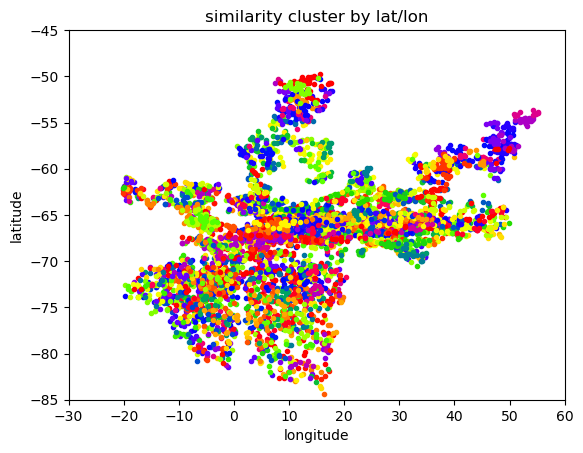

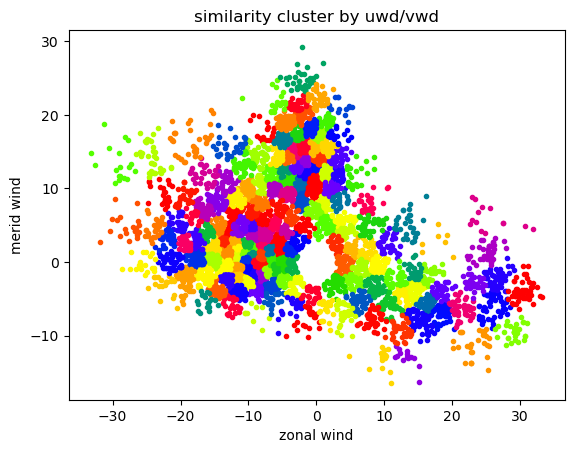

In [19]:
nClusters=np.size(np.unique(gdfEsub['similGroup'].values))
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))
for c in range(nClusters):
    clu=np.unique(gdfEsub['similGroup'].values)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'lon'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'lat'].values,
                 '.',
                 color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'lon'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'lat'].values,
                 '.',
                 color=pcol)
        
plt.xlim((-30.,60.))
plt.ylim((-85.,-45.))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('similarity cluster by lat/lon')
plt.show()


for c in range(nClusters):
    clu=np.unique(gdfEsub['similGroup'].values)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'uob'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'vob'].values,
                 '.',
                 color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'uob'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'vob'].values,
                 '.',
                 color=pcol)

plt.xlabel('zonal wind')
plt.ylabel('merid wind')
plt.title('similarity cluster by uwd/vwd')
plt.show()

In [20]:
# select a similaricy cluster
si = np.unique(gdfEsub['similGroup'].values)[7]
gdfEsubcl = gdfEsub.loc[gdfEsub['similGroup']==si]
gdfEsubcl

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
609,641,648,POINT (236979.152 -7126323.515),-64.016853,2.128820,387.600006,-0.933333,-10.858522,0.949998,954,1,7
633,665,672,POINT (394559.686 -7188223.070),-64.572906,3.544390,435.100006,-0.933333,-10.740836,1.128907,980,1,7
929,961,968,POINT (99721.114 -7056756.052),-63.391918,0.895810,475.000000,-0.783333,-10.405248,2.022575,2048,1,7
1641,1800,1824,POINT (1342513.106 -7311464.189),-65.680000,12.060000,525.000000,-1.466667,-10.421735,1.279628,38281,1,7
2017,2176,2200,POINT (1788705.022 -7444317.690),-66.873444,16.068211,400.200012,-2.616667,-10.719499,1.316189,38879,1,7
2254,2413,2437,POINT (1937337.673 -7528152.124),-67.626541,17.403400,483.600006,-2.483333,-10.442480,1.097549,39667,1,7
2885,3458,3516,POINT (2335772.265 -7329569.573),-65.842644,20.982599,412.799988,-1.733333,-10.370728,1.642562,74121,1,7
2923,3496,3554,POINT (2398183.523 -7405649.046),-66.526077,21.543249,406.399994,-1.733333,-10.223226,1.255254,74159,1,7
2931,3504,3562,POINT (2984006.887 -7321758.558),-65.772476,26.805790,409.799988,-1.733333,-10.012597,1.946252,74167,1,7
3080,3655,3713,POINT (2265471.856 -7458727.768),-67.002892,20.351080,429.600006,-2.616667,-10.360425,0.906420,74418,1,7


In [21]:
# list number of neighbors for each ob in gdfEsubcl
for i in range(len(gdfEsubcl)):
    nprox=np.size(np.where(np.isin(gdfEsubcl['level_0'].values,w.neighbors[gdfEsubcl['level_0'].values[i]])))
    npres=np.size(np.where(np.isin(gdfEsubcl.index,neighPresList[gdfEsubcl.index[i]])))
    ntime=np.size(np.where(np.isin(gdfEsubcl.index,neighTimeList[gdfEsubcl.index[i]])))
    print(i,nprox,npres,ntime)

0 0 9 15
1 0 22 15
2 0 18 15
3 0 6 15
4 0 13 18
5 0 16 18
6 1 16 23
7 1 16 23
8 2 16 23
9 0 18 18
10 0 21 18
11 2 21 23
12 3 20 23
13 2 21 23
14 1 21 23
15 0 21 15
16 1 20 23
17 1 20 23
18 1 22 18
19 1 17 18
20 1 17 18
21 1 17 18
22 0 17 23


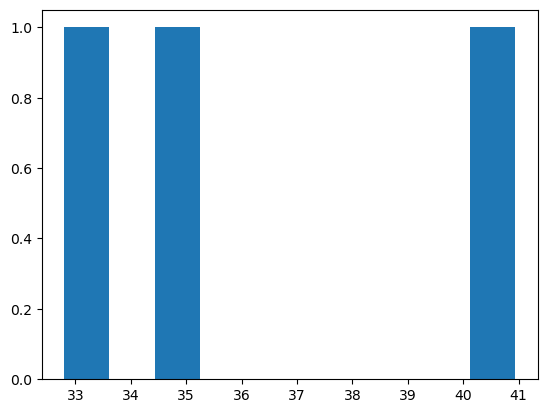

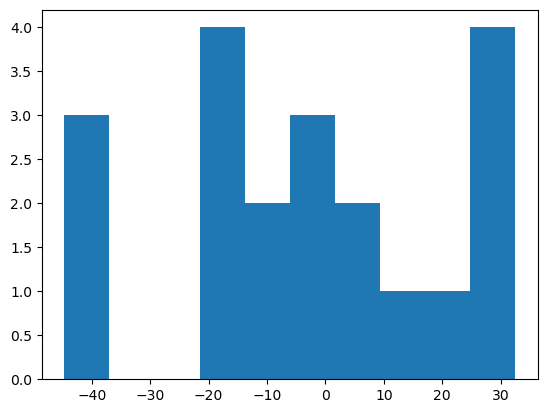

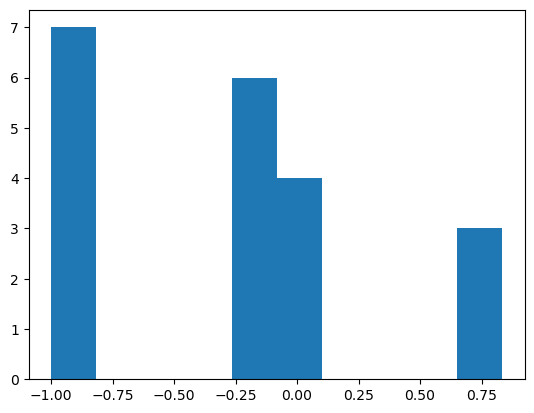

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
3327,3902,3960,POINT (2910079.541 -7334544.775),-65.887337,26.141689,451.100006,-1.616667,-10.939741,1.149813,75223,1,7
2931,3504,3562,POINT (2984006.887 -7321758.558),-65.772476,26.805790,409.799988,-1.733333,-10.012597,1.946252,74167,1,7
3326,3901,3959,POINT (2819360.891 -7352352.904),-66.047310,25.326750,433.100006,-1.616667,-10.074421,1.595632,75222,1,7
3340,3915,3973,POINT (2835218.390 -7351567.301),-66.040253,25.469200,438.600006,-1.616667,-10.298788,1.447400,75237,1,7


In [22]:
i=12
proxlist=np.where(np.isin(gdfEsubcl['level_0'].values,w.neighbors[gdfEsubcl['level_0'].values[i]]))[0]
preslist=np.where(np.isin(gdfEsubcl.index,neighPresList[gdfEsubcl.index[i]]))[0]
timelist=np.where(np.isin(gdfEsubcl.index,neighTimeList[gdfEsubcl.index[i]]))[0]
idx4d=np.intersect1d(proxlist,np.intersect1d(preslist,timelist))

plt.hist(haversine_np(gdfEsubcl['lat'].values[proxlist],gdfEsubcl['lon'].values[proxlist],gdfEsubcl['lat'].values[i],gdfEsubcl['lon'].values[i]))
plt.show()
plt.hist(gdfEsubcl['pre'].values[preslist]-gdfEsubcl['pre'].values[i])
plt.show()
plt.hist(gdfEsubcl['tim'].values[preslist]-gdfEsubcl['tim'].values[i])
plt.show()

ids = np.append(i,idx4d)
gdfEsubcl.iloc[ids]